In [39]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns


In [3]:
def load_config():
    # Get the absolute path of the project root (one directory up)
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

    # Normalize the project_root to ensure it's correctly formatted
    project_root = os.path.normpath(project_root)
    
    config_path = os.path.join(project_root, 'config.json')

    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at expected location: {config_path}")

    with open(config_path, 'r') as f:
        config = json.load(f)

    return config, project_root


In [4]:
config, project_root = load_config()

csv_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["enterprise"]))
csv_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["mobile"]))
csv_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_groups_v15"]["ics"]))
technique_path_enterprise = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["enterprise"]))
technique_path_mobile = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["mobile"]))
technique_path_ics = os.path.normpath(os.path.join(project_root, config["data_directory"], config["file_paths_techniques"]["ics"]))

#csv_path_enterprise, csv_path_mobile, csv_path_ics


In [5]:
df_group_enterprise = pd.read_excel(csv_path_enterprise, sheet_name='groups')

# Extract the unique IDs from the first sheet (universe of techniques)
observed_group_ids_enterprise = df_group_enterprise['ID'].unique()
print(len(observed_group_ids_enterprise))


148


In [6]:
df_group_mobile = pd.read_excel(csv_path_mobile, sheet_name='groups')

observed_group_ids_mobile = df_group_mobile['ID'].unique()
print(len(observed_group_ids_mobile))

13


In [7]:
df_group_ics = pd.read_excel(csv_path_ics, sheet_name='groups')

observed_group_ids_ics = df_group_ics['ID'].unique()
print(len(observed_group_ids_ics))

14


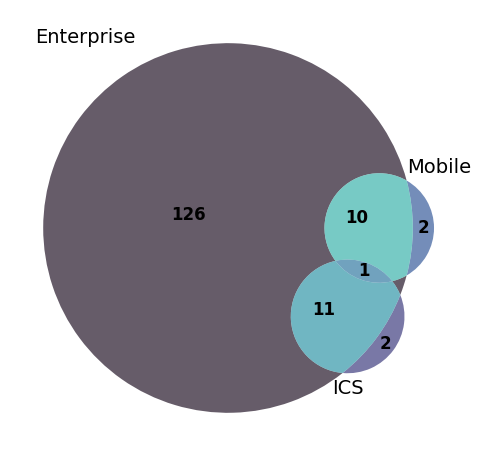

In [42]:
##Ploting group intersection figure across the domains
# Convert lists to sets for easier manipulation
enterprise_set = set(observed_group_ids_enterprise)
mobile_set = set(observed_group_ids_mobile)
ics_set = set(observed_group_ids_ics)

# Create the figure
plt.figure(figsize=(5, 5))

# Create Venn diagram
venn = venn3([enterprise_set, mobile_set, ics_set], ('Enterprise', 'Mobile', 'ICS'))

# Get the mako colormap
cmap = plt.get_cmap('mako')

# Define colors for each of the 7 Venn subsets (7 = 2^3 - 1)
# We pick colors spaced evenly from the colormap
colors = [cmap(x) for x in [0.1, 0.4, 0.7, 0.3, 0.6, 0.8, 0.5]]

# Apply colors to each patch if it exists
for patch, color in zip(venn.patches, colors):
    if patch:  # patch can be None if the subset is empty
        patch.set_facecolor(color)
        patch.set_alpha(0.7)  # Adjust transparency if you like

# Bold and increase font size for set labels
for label in venn.set_labels:
    label.set_fontsize(14)
    #label.set_fontweight('bold')

# Bold and increase font size for subset labels (numbers)
for subset_label in venn.subset_labels:
    if subset_label:
        subset_label.set_fontsize(12)
        subset_label.set_fontweight('bold')

plt.tight_layout()

# Optional title and save
# plt.title("Venn Diagram of Group IDs across Enterprise, Mobile, and ICS", fontsize=16)
plt.savefig("figure/venn_diagram_groups.pdf", format='pdf')

plt.show()

In [17]:
# Find techniques that are in all three sets (intersection)
groups_in_all_three = enterprise_set & mobile_set & ics_set

# Find techniques that are only in mobile (difference with enterprise and ICS)
groups_only_in_mobile = mobile_set - (enterprise_set | ics_set)

# Find techniques that are only in ICS (difference with enterprise and mobile)
groups_only_in_ics = ics_set - (enterprise_set | mobile_set)

# Output the results
print("Groups in all three categories (Enterprise, Mobile, ICS):")
print(groups_in_all_three)

print("Groups only in Mobile (not in Enterprise or ICS):")
print(groups_only_in_mobile)

print("Groups only in ICS (not in Enterprise or Mobile):")
print(groups_only_in_ics)


Groups in all three categories (Enterprise, Mobile, ICS):
{'G0034'}
Groups only in Mobile (not in Enterprise or ICS):
{'G0097', 'G1029'}
Groups only in ICS (not in Enterprise or Mobile):
{'G1027', 'G1000'}


In [24]:
# Helper function to load 'techniques in all the domains' data
def load_techniques(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques')
    return df[['ID', 'name']]

dfs = [load_techniques(f) for f in [technique_path_enterprise, technique_path_mobile, technique_path_ics]]
all_techniques = pd.concat(dfs, ignore_index =True)

#all_techniques

In [27]:
# Helper function to load 'techniques used by group in all the domains' data
def load_techniques_used_group(file_path):
    df = pd.read_excel(file_path, sheet_name='techniques used')
    return df[['source ID', 'target ID']]

# Combine group technique mappings from all sources
dfs = [load_techniques_used_group(f) for f in [csv_path_enterprise, csv_path_mobile, csv_path_ics]]
combined_df = pd.concat(dfs, ignore_index=True)

In [28]:
# Calculate observed and unobserved techniques
observed_ids = combined_df['target ID'].unique()
unobserved_techniques = all_techniques[~all_techniques['ID'].isin(observed_ids)]

# Stats
total_techniques = len(all_techniques)
observed_techniques = len(observed_ids)
unobserved_count = len(unobserved_techniques)
unique_groups = combined_df['source ID'].nunique()

# Output statistics
print(f"Total techniques reported by MITRE: {total_techniques}")
print(f"Total techniques observed across all domains among groups: {observed_techniques}")
print(f"Techniques not observed in any domain: {unobserved_count}")
print(f"Total unique groups: {unique_groups}")

# Display sample group-to-techniques mapping
print("\nSample group techniques mapping:")
sample_groups = combined_df['source ID'].dropna().unique()[:3]
for group_id in sample_groups:
    techniques = combined_df[combined_df['source ID'] == group_id]['target ID'].unique()
    print(f"\nGroup ID: {group_id}")
    print(f"Techniques used ({len(techniques)}): {list(techniques)}")

Total techniques reported by MITRE: 839
Total techniques observed across all domains among groups: 451
Techniques not observed in any domain: 388
Total unique groups: 148

Sample group techniques mapping:

Group ID: G0099
Techniques used (9): ['T1105', 'T1204.002', 'T1036.004', 'T1571', 'T1027', 'T1053.005', 'T1566.001', 'T1588.002', 'T1059.005']

Group ID: G0006
Techniques used (23): ['T1560.001', 'T1119', 'T1005', 'T1583.001', 'T1584.001', 'T1585.002', 'T1003.001', 'T1087.001', 'T1114.001', 'T1588.001', 'T1036.005', 'T1135', 'T1550.002', 'T1057', 'T1021.001', 'T1114.002', 'T1566.001', 'T1566.002', 'T1016', 'T1049', 'T1007', 'T1588.002', 'T1059.003']

Group ID: G0005
Techniques used (5): ['T1102.002', 'T1568.003', 'T1203', 'T1204.002', 'T1566.001']


In [30]:
# Optional: show sample of unobserved techniques
pd.set_option('display.max_rows', 35)
print("\nSample of unobserved techniques (ID and name):")
print(unobserved_techniques.tail(10))


Sample of unobserved techniques (ID and name):
        ID                              name
825  T0881                      Service Stop
827  T0856           Spoof Reporting Message
830  T0894     System Binary Proxy Execution
831  T0857                   System Firmware
832  T0882  Theft of Operational Information
833  T0864             Transient Cyber Asset
834  T0855      Unauthorized Command Message
835  T0863                    User Execution
837  T0860               Wireless Compromise
838  T0887                 Wireless Sniffing


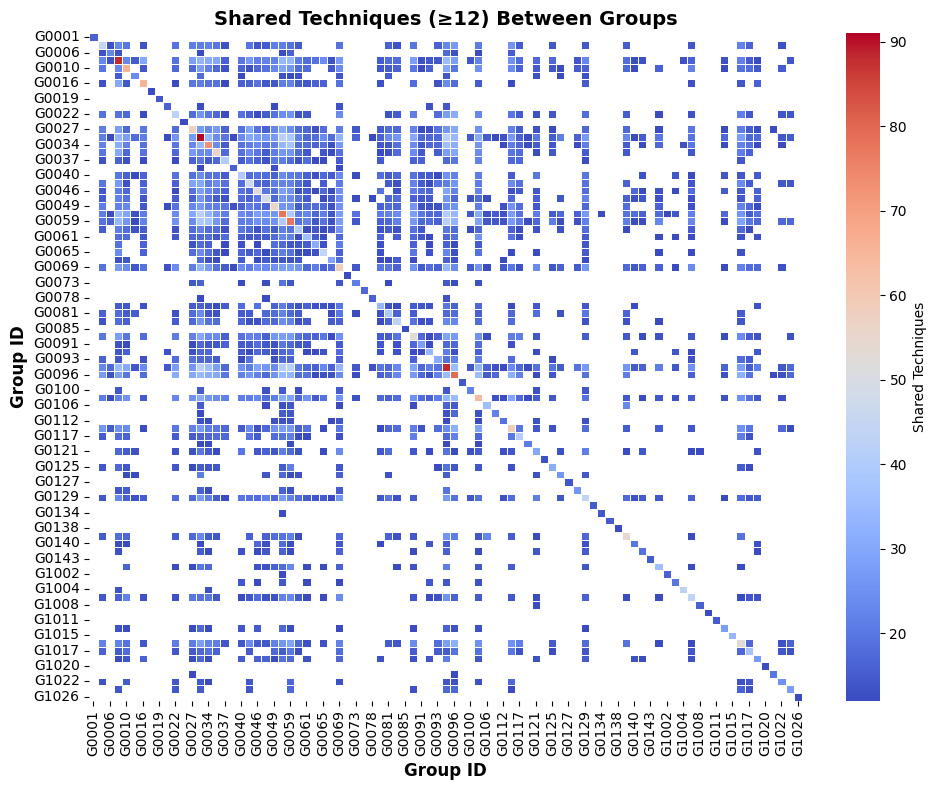

In [18]:
# Load the data
df_group_enterprise = pd.read_excel(csv_path_enterprise, sheet_name='techniques used')

# Step 2: Group techniques by "Source ID"
grouped_techniques = df_group_enterprise.groupby('source ID')['target ID'].apply(set)

# Step 3: Initialize an empty co-occurrence matrix
group_ids = grouped_techniques.index
cooccurrence_matrix = pd.DataFrame(0, index=group_ids, columns=group_ids)

# Step 4: Fill the co-occurrence matrix with counts of similar techniques
for group_a in group_ids:
    for group_b in group_ids:
        # Find intersection of techniques between group A and group B
        common_techniques = grouped_techniques[group_a] & grouped_techniques[group_b]
        cooccurrence_matrix.loc[group_a, group_b] = len(common_techniques)

# Set a threshold for minimum shared techniques between groups
min_shared_techniques = 12  # You can adjust this threshold

## Mask entries below the threshold
masked_matrix = cooccurrence_matrix.where(cooccurrence_matrix >= min_shared_techniques)

# Drop rows and columns that are all NaN (i.e., no strong overlaps)
filtered_cooccurrence_matrix = masked_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)

plt.figure(figsize=(10, 8))
sns.heatmap(
    filtered_cooccurrence_matrix,
    annot=False,
    fmt='.0f',
    cmap='coolwarm',
    linewidths=0.5,
    cbar_kws={"label": "Shared Techniques"}
)
plt.title('Shared Techniques (≥12) Between Groups', fontsize=14, fontweight='bold')
plt.xlabel('Group ID', fontsize=12, fontweight='bold')
plt.ylabel('Group ID', fontsize=12, fontweight='bold')
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("figure/enterprise_technique_cooccurrence_heatmap_12.pdf", format='pdf')
plt.show()



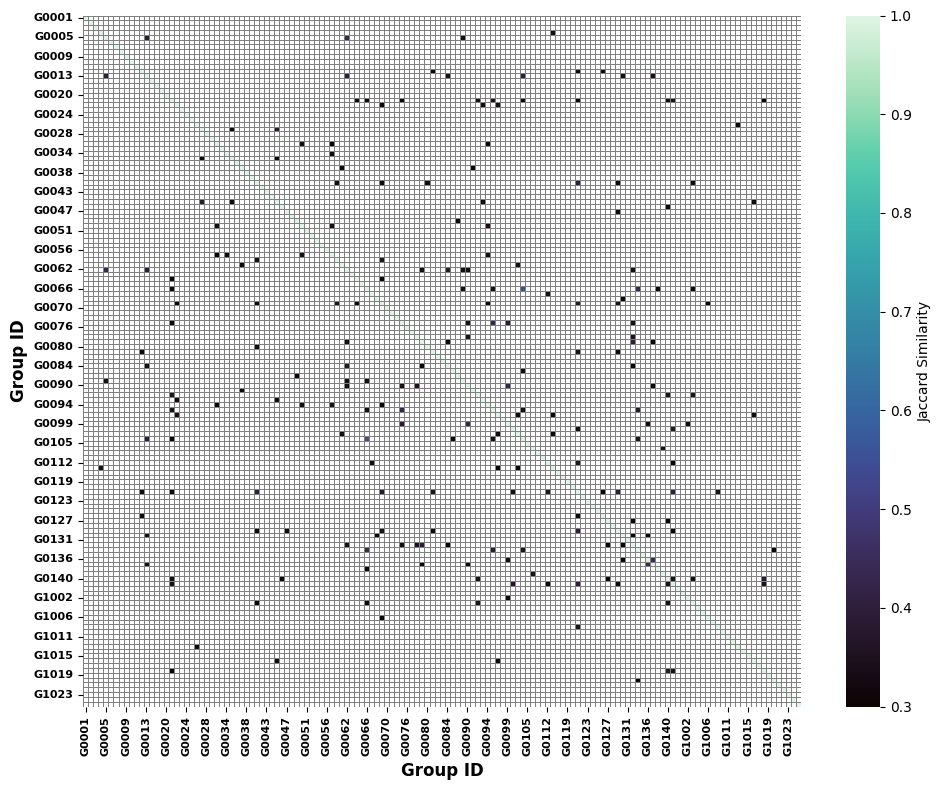

In [43]:
# Load the data
df_group_enterprise = pd.read_excel(csv_path_enterprise, sheet_name='techniques used')

# Step 1: Group techniques by "Source ID"
grouped_techniques = df_group_enterprise.groupby('source ID')['target ID'].apply(set)

# Step 2: Initialize an empty similarity matrix
group_ids = grouped_techniques.index
jaccard_matrix = pd.DataFrame(0.0, index=group_ids, columns=group_ids)

# Step 3: Compute Jaccard similarity between each pair of groups
for group_a in group_ids:
    for group_b in group_ids:
        set_a = grouped_techniques[group_a]
        set_b = grouped_techniques[group_b]
        intersection = set_a & set_b
        union = set_a | set_b
        jaccard_score = len(intersection) / len(union) if union else 0
        jaccard_matrix.loc[group_a, group_b] = jaccard_score

# Step 4: Apply a threshold to focus on stronger overlaps
min_jaccard_threshold = 0.3  # Tune this based on your needs
masked_matrix = jaccard_matrix.where(jaccard_matrix >= min_jaccard_threshold)

# Remove rows and columns that have no strong connections
filtered_matrix = masked_matrix.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Step 5: Plot the heatmap
plt.figure(figsize=(10, 8))

sns.heatmap(
    filtered_matrix,
    annot=False,
    fmt=".2f",
    cmap='mako',
    linewidths=0.6,
    linecolor='gray',
    cbar_kws={'label': 'Jaccard Similarity'}
)
plt.xticks(rotation=90, fontsize=8, weight='bold')
plt.yticks(rotation=0, fontsize=8, weight='bold')


# Step 6: Final touches for academic style
#plt.title('Technique Similarity Between Groups (Jaccard Index ≥ 0.3)', fontsize=14, weight='bold')
plt.xlabel('Group ID', fontsize=12, weight='bold')
plt.ylabel('Group ID', fontsize=12, weight='bold')
#plt.xticks(rotation=90, fontsize=8, weight='bold')
#plt.yticks(rotation=0, fontsize=8, weight='bold')

plt.xticks(rotation=90, fontsize=8, weight='bold', ha='center')
plt.yticks(fontsize=8, weight='bold')


plt.tight_layout()
plt.savefig("figure/enterprise_technique_jaccard_heatmap_0.5.pdf", format='pdf', dpi=300, bbox_inches='tight')
plt.show()
